<a href="https://colab.research.google.com/github/caua-sathler/NEURAL-NETWORKS/blob/main/MLP-SGD/MLP_Adam_Heart_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Entre 79% e 81% de acurácia somente com o Adam**

Epoch [10/100] Loss: 0.3233, Train Acc: 87.26%
Epoch [20/100] Loss: 0.2056, Train Acc: 93.40%
Epoch [30/100] Loss: 0.0555, Train Acc: 98.58%
Epoch [40/100] Loss: 0.0040, Train Acc: 100.00%
Epoch [50/100] Loss: 0.0013, Train Acc: 100.00%
Epoch [60/100] Loss: 0.0005, Train Acc: 100.00%
Epoch [70/100] Loss: 0.0001, Train Acc: 100.00%
Epoch [80/100] Loss: 0.0000, Train Acc: 100.00%
Epoch [90/100] Loss: 0.0000, Train Acc: 100.00%
Epoch [100/100] Loss: 0.0000, Train Acc: 100.00%

Final Test Loss: 3.0471
Final Test Accuracy: 80.22%


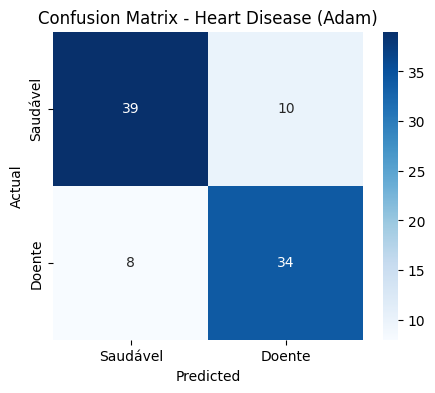

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

# 1) Carregar dataset Heart Disease (versão Cleveland) do UCI
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
           "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]

df = pd.read_csv(url, names=columns)

# Substituir "?" por NaN e converter para float
df.replace("?", float("nan"), inplace=True)
df = df.astype(float)

# Preencher valores ausentes com a média das colunas
df.fillna(df.mean(), inplace=True)

# Converter o target para binário: 0 = saudável, 1 = doente
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

# 2) Separar features (X) e rótulos (y)
X = df.drop(columns=['target']).values  # shape: (N, 13)
y = df['target'].values                # 0 ou 1

# 3) Dividir em treino e teste (70%/30%), estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 4) Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 5) Converter para tensores PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# 6) Definir a MLP
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)  # logits
        return x

# 7) Instanciar a rede
model = MLP(input_dim=13, output_dim=2)

# 8) Definir função de perda e otimizador (Adam)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# 9) Treinamento (Adam) - sem PSO
epochs = 100
batch_size = 16

for epoch in range(epochs):
    model.train()

    # Embaralhar os dados
    indices = torch.randperm(X_train.shape[0])
    X_train = X_train[indices]
    y_train = y_train[indices]

    # Mini-batch
    total_loss = 0
    correct = 0
    total = 0

    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        # Zerar gradientes
        optimizer.zero_grad()

        # Forward
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward
        loss.backward()

        # Update
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)

        # Acurácia no batch
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    # Perda e acurácia de treino (média)
    avg_loss = total_loss / total
    train_acc = 100.0 * correct / total

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Loss: {avg_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%")

# 10) Avaliar no conjunto de teste
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    loss_test = criterion(outputs, y_test)
    _, predicted_test = torch.max(outputs.data, 1)
    accuracy_test = 100.0 * (predicted_test == y_test).sum().item() / len(y_test)

print(f"\nFinal Test Loss: {loss_test.item():.4f}")
print(f"Final Test Accuracy: {accuracy_test:.2f}%")

# 11) Matriz de confusão
conf_mat = confusion_matrix(y_test.numpy(), predicted_test.numpy())
plt.figure(figsize=(5,4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Saudável", "Doente"],
            yticklabels=["Saudável", "Doente"])
plt.title("Confusion Matrix - Heart Disease (Adam)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
